# Transition state

Once we have a suitable candidate for transition state we can optimize the structure for a transition state. As explained before the transition state will be characterized by a vanishing gradient and one negative Hessian 
eigenvalue. Therefore, in essence, we are exploring the PES looking for a maximum.<br />
<br />
To ilustrate the concepts we will use a simple example in which we will perform the Intrinsic Reaction Coordinate (IRC) method. So, we will start with a transition state candidate and optimize it to transition state. Then we will just minimize the energy in the backward path and the forward path to obtain the reactant and the product as illustrated in the following figure:<br />
```{figure} ../../img/pes/irc.png
```

### Intrinsic Reaction Coordinate method

The Intrinsic Reaction Coordinate method traces the minimum energy pathway of a chemical reaction, connecting an optimized transition state characterized by a single imaginary frequency to the neighbouring reactant and product minima. <br />
<br />
The calculation starts from the optimized TS structure, after the Hessian and vibrational frequencies have been determined. The eigenvector, corresponding to the imaginary vibrational mode defines the displacement vector, which sets the direction along which the system initially moves away from the TS.<br />
<br />
The first step is taken in the positive "forward" direction along this eingenvector using mass-weighted internal coordinates. At each step, the Hessian is updated, and the subsequent steps are guided by the instantaneous acceleration vectors. The procedure continues iteratively until convergence is reached in the "forward" direction, then is repeated in the negative "backward" direction to complete the full energy profile. 

In [1]:
import veloxchem as vlx
import py3Dmol as p3d

In [2]:
ts_guess = '''8
Initial geometry
C        1.4059000000    0.8128000000    0.0009000000
C        1.5654000000   -0.3926000000    0.0009000000
N       -1.0383000000    1.0196000000   -0.0052000000
H       -2.0386000000    1.4291000000    0.0210000000
H        1.3741000000    1.8940000000   -0.0007000000
H        1.9546000000   -1.4028000000    0.0003000000
N       -0.4958000000   -1.3375000000   -0.0011000000
N       -1.1970000000   -0.3166000000    0.0018000000
'''

In [17]:
molecule = vlx.Molecule.from_xyz_string(ts_guess)
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**Fig 1**: TS candidate

##### Setting up the SCF driver

In [4]:
basis = vlx.MolecularBasis.read(molecule,"def2-svp")
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.conv_thresh = 1.0e-6
scf_drv.xcfun = "b3lyp"
scf_drv.grid_level = 4
scf_drv.ostream.mute()
scf_results = scf_drv.compute(molecule,basis)

##### Setting up the gradient driver

In [5]:
scf_grad_drv = vlx.ScfGradientDriver(scf_drv)
scf_grad_drv.compute (molecule,basis)

##### Setting up the optimization driver

In [6]:
scf_opt_drv = vlx.OptimizationDriver(scf_drv)
scf_opt_drv.transition = True # We set the option to find transition state
scf_opt_drv.hessian = 'first+last'
scf_opt_drv.ostream.mute()
scf_opt_ts = scf_opt_drv.compute(molecule, basis, scf_results)

##### Geometry of the optimized transition state

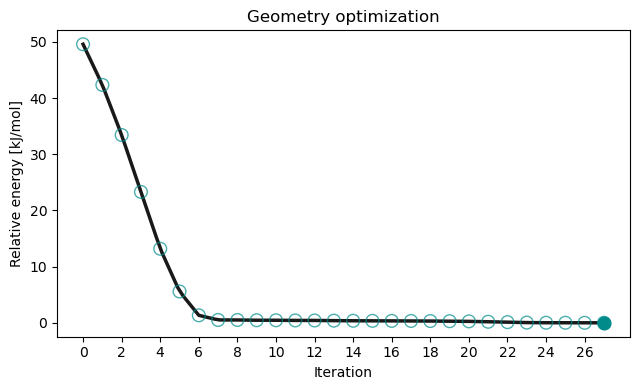

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

interactive(children=(IntSlider(value=27, description='step', max=27), Output()), _dom_classes=('widget-intera…

In [7]:
scf_opt_drv.show_convergence(scf_opt_ts)

##### Vibrational Analysis
To confirm that we obtained the TS, we will perform a vibrational analysis.

In [10]:
opt_molecule = vlx.Molecule.from_xyz_string(scf_opt_ts['final_geometry'])
opt_scf_drv = vlx.ScfRestrictedDriver()
opt_scf_drv.xcfun = "b3lyp"
opt_scf_results = opt_scf_drv.compute(opt_molecule, basis)

vib_drv = vlx.VibrationalAnalysis(opt_scf_drv)
vib_drv.update_settings(method_dict={'xcfun': 'b3lyp', 'grid_level':4})

vib_results = vib_drv.compute(opt_molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

##### Animate the normal mode of choice (indexing starts with 1)

In [11]:
vib_drv.animate(vib_results, mode=1)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### IRC
After obtaining the TS, perform an intrinsic reaction coordinate (IRC) calculation to find the product and reactant.

##### Setting up the SCF driver

In [19]:
molecule = vlx.Molecule.read_xyz_string(scf_opt_ts["final_geometry"])
basis = vlx.MolecularBasis.read(molecule,"def2-svp")

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.conv_thresh = 1.0e-6
scf_drv.xcfun = "b3lyp"
scf_drv.grid_level = 4
scf_irc_results = scf_drv.compute(molecule,basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

##### Setting up the gradient driver

In [20]:
scf_grad_drv = vlx.ScfGradientDriver(scf_drv)
scf_grad_drv.compute(molecule,basis)

                                                                                                                          
                                                   SCF Gradient Driver                                                    
                                                                                                                          
                          Gradient Type                   : Analytical                                                    
                                                                                                                          
                                              Molecular Geometry (Angstroms)                                              
                                                                                                                          
                          Atom         Coordinate X          Coordinate Y          Coordinate Z                           
                

##### Setting up the optimization driver for the IRC

In [21]:
scf_opt_drv = vlx.OptimizationDriver(scf_grad_drv)
scf_opt_drv.irc = True  
scf_opt_drv.hessian = 'first'  # IRC usually uses Hessian from TS
scf_opt_drv.ostream.mute()
scf_opt_irc = scf_opt_drv.compute(molecule,basis,scf_irc_results)

##### Visualization of the optimized reactant and product geometries

In [23]:
scf_opt_irc["opt_energies"] # use to investigate energies of reactant and product

[np.float64(-242.04407422005022),
 np.float64(-242.044073930066),
 np.float64(-242.04407261220445),
 np.float64(-242.04407050517236),
 np.float64(-242.0440681675856),
 np.float64(-242.04406623076426),
 np.float64(-242.0440584379007),
 np.float64(-242.04404118386623),
 np.float64(-242.04379683698338),
 np.float64(-242.0431403036591),
 np.float64(-242.04184646285162),
 np.float64(-242.0398373239964),
 np.float64(-242.03715179403363),
 np.float64(-242.0338613664231),
 np.float64(-242.030043361477),
 np.float64(-242.02577329527054),
 np.float64(-242.02112312962143),
 np.float64(-242.01616063989732),
 np.float64(-242.01094906597908),
 np.float64(-242.00554695273797),
 np.float64(-242.00000811220406),
 np.float64(-241.9943816581402),
 np.float64(-241.9887124839437),
 np.float64(-241.98304083828646),
 np.float64(-241.97740365271437),
 np.float64(-241.9718347595887),
 np.float64(-241.96636517138612),
 np.float64(-241.96102325509733),
 np.float64(-241.9558347924236),
 np.float64(-241.9508230002

In [34]:
reactant = vlx.Molecule.from_xyz_string(scf_opt_irc['opt_geometries'][-1])
product = vlx.Molecule.from_xyz_string(scf_opt_irc['opt_geometries'][0])
reactant.show()
product.show()
reactant.write_xyz_file('irc_reactant.xyz')
product.write_xyz_file('irc_product.xyz')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

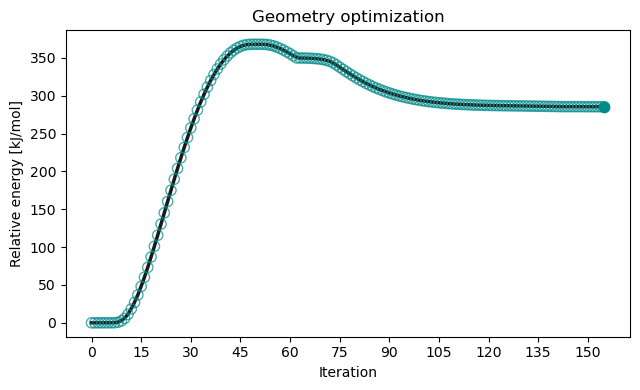

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

interactive(children=(IntSlider(value=155, description='step', max=155), Output()), _dom_classes=('widget-inte…

In [26]:
scf_opt_drv.show_convergence(scf_opt_irc)

### Calculation of Thermodynamic and Kinetic Parameters

With calculated values of reactant, product, and transition state, we now compute thermodynamic and kinetic quantities for a chemical reaction:

- Activation free energy ($\Delta G^\ddagger$)
- Reaction rate via Transition State Theory
- Reaction free energy ($\Delta G^\circ$)

- **Activation free energy** <br>
By definition the activation free energy is $\Delta G^{\ddagger} = G^{\ddagger} - G_{react}$.
From the outputs of the TS and reactant we can get the activation energy $\Delta G^{\ddagger}$ that we can relate with TST to estimate the rate of the reaction. 

In [89]:
delta_g = scf_opt_ts['opt_energies'][-1]-scf_opt_irc['opt_energies'][-1]
print(f"Activation energy is {627.5095 * delta_g:.2f} kcal/mol")

Activation energy is 19.73 kcal/mol


- **Reaction rate**<br>
Applying Transition State Theory we can estimate the rate with the Eyring equation: <br />
$ k = \frac{k_B T}{h}\exp(\frac{-\Delta G^{\ddagger}}{RT}) $

In [84]:
import numpy as np

def rate(delta_g):
    k_B = 1.3806e-23  # J/K
    h = 6.6261e-34    # J s
    R = 1.987e-3      # kcal/mol K
    T = 300           # K

    delta_g_kcal = delta_g * 627.5095
    
    # Eyring equation
    k = (k_B * T / h) * np.exp(-delta_g_kcal / (R * T))
    return k

In [90]:
print(f"The reaction rate is {rate(delta_g):.3e} s-1")

The reaction rate is 2.620e-02 s-1


- **Reaction free energy** <br>
Finally, we can determine the reaction free energy $\Delta G^{0}$ as the free energy difference between reactant and product:

In [93]:
reaction_energy = scf_opt_irc["opt_energies"][0] - scf_opt_irc["opt_energies"][-1] # a.u
reaction_energy_kcal = reaction_energy *627.5095 # kcal/mol

In [94]:
print(f"Reaction free energy is {reaction_energy_kcal:.2f} kcal/mol")

Reaction free energy is -68.23 kcal/mol


With all that information we have proffiled the reaction energetics.